In [69]:
import datetime
import numpy as np

import plotting
import matplotlib.pyplot as plt
%matplotlib inline

import openeye.oechem as oechem
import openeye.oeiupac as oeiupac
import openeye.oeomega as oeomega
import openeye.oedepict as oedepict

from openforcefield.typing.engines.smirnoff.forcefield import *
from openforcefield.typing.engines.smirnoff.forcefield_utils import get_molecule_parameterIDs
from openforcefield.utils import *

In [70]:
now = datetime.datetime.utcnow()
today = now.strftime("%Y-%m-%d")
print('This notebook was last rendered on {}.'.format(today))

This notebook was last rendered on 2018-09-21.


In [2]:
def depictAtomByIdx(mol_copy, atomIdxList, supH = True, width=900, height=500):
    mol = oechem.OEMol(mol_copy)
    OEGenerate2DCoordinates(mol)
    atomBondSet = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in atomIdxList:
            atomBondSet.AddAtom( atom)
            for bond in atom.GetBonds():
                nbrAtom = bond.GetNbr(atom)
                nbrIdx = nbrAtom.GetIdx()
                if (nbrIdx in atomIdxList) and nbrIdx>atom.GetIdx():
                    atomBondSet.AddBond( bond)
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    aroStyle = oedepict.OEHighlightStyle_Color
    aroColor = oechem.OEColor(oechem.OEGrey)
    oedepict.OEAddHighlighting(disp, aroColor, aroStyle, 
                               oechem.OEIsAromaticAtom(), oechem.OEIsAromaticBond() )
    hstyle = oedepict.OEHighlightStyle_BallAndStick
    hcolor = oechem.OEColor(oechem.OELightGreen)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, atomBondSet)
    #ofs = oechem.oeosstream()
    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img, disp)
    #oedepict.OERenderMolecule(ofs, 'png', disp)
    #ofs.flush()
    #return Image(data = "".join(ofs.str()))
    return Image(oedepict.OEWriteImageToString("png",img))



In [3]:
def getMolParamIDToAtomIndex( oemol, ff):
    """Take an OEMol and a SMIRNOFF forcefield object and return a dictionary,
    keyed by parameter ID, where each entry is a tuple of
    ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
    corresponding to that parameter ID and a list of the atom groups in that
    molecule that parameter is applied to.

    Parameters
    ----------
    oemol : OEMol
        OpenEye OEMol with the molecule to investigate.
    ff : ForceField
        SMIRNOFF ForceField object (obtained from an ffxml via ForceField(ffxml)) containing FF of interest.

    Returns
    -------
    param_usage : dictionary
        Dictionary, keyed by parameter ID, where each entry is a tuple of
        ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
        corresponding to that parameter ID and a list of the atom groups in
        that molecule that parameter is applied to.

    """
    labels = ff.labelMolecules([oemol])
    param_usage = {}
    for mol_entry in range(len(labels)):
        for force in labels[mol_entry].keys():
            for (atom_indices, pid, smirks) in labels[mol_entry][force]:
                if not pid in param_usage:
                    param_usage[pid] = (smirks, [atom_indices])
                else:
                    param_usage[pid][1].append( atom_indices )

    return param_usage

In [4]:
def GetAtomInfo(mol, indices, skip_atoms = []):
    #print(indices)
    atoms_by_index = dict()
    charges_by_index = dict()
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        if idx in indices:
            atoms_by_index[idx] = atom
            charge = atom.GetFormalCharge()
            if charge == 0:
                charges_by_index[idx] = ''
            elif charge > -1:
                charges_by_index[idx] = '+%i' % charge
            else:
                charges_by_index[idx] = str(charge)
    atoms = [(atoms_by_index[idx],charges_by_index[idx]) for idx in indices]
    types = [atom.GetType() for (atom,charge) in atoms]
    atom_smarts = ['[#%i%s]' % (atom.GetAtomicNum(),charge) for (atom,charge) in atoms]
    smarts = '~'.join(atom_smarts)
    types = '~'.join(types)
    
    for (atom, charge) in atoms:
        if atom.GetAtomicNum() in skip_atoms:
            return (True, smarts, types)
    

    return (False, smarts, types)
    
def DepictMolWithParam(mol, indice_list, supH = False, print_atoms = True, skip_atoms = []):
    skip_count = 0
    for IdxByOccurrence in indice_list:
        
        skip_it, approx_smarts, types = GetAtomInfo(mol, IdxByOccurrence, skip_atoms)
        
        if skip_it:
            skip_count += 1
            continue
            
        if print_atoms:
            print("Approximate SMARTS: %s" % approx_smarts)
            print("Current Atom Types: %s" % types)
        display(depictAtomByIdx(mol, IdxByOccurrence, supH = supH))
    if skip_count > 0:
        skips = ','.join([str(i) for i in skip_atoms])
        print("This molecule contains %i fragment(s) with at least one atom in (%s)" % (skip_count, skips))

In [5]:
def make_param_histogram(param_id_counts, param_ids, letter, title):
    # Graph occurrences of bond parameters
    parm_ids = [ pid for pid in param_ids if pid[0]==letter]
    parm_ids.sort()
    counts_parms = [param_id_counts[parm_id] for parm_id in parm_ids]
    #print( parm_ids)
    #print( counts_parms)
    split = int(len(parm_ids)/2)
    
    indices = np.arange(len(parm_ids))
    fix, ax = plt.subplots(2,1,figsize=(16,5))
    ax[0].set_yscale('log', nonposy='clip')
    ax[1].set_yscale('log', nonposy='clip')
    
    rects2 = ax[0].bar(indices[0:split], counts_parms[0:split] )
    ax[0].set_ylabel('Count')
    ax[0].set_xticks( indices[0:split])
    ax[0].set_xticklabels( parm_ids[0:split], rotation=-60, ha='left')
    ax[0].set_xlim(indices[0], indices[split])
    plt.yscale('log',nonposy='clip')
    rects2 = ax[1].bar(indices[split:], counts_parms[split:])
    ax[1].set_ylabel('Count')
    ax[1].set_xticks( indices[split:])
    ax[1].set_xticklabels( parm_ids[split:], rotation=-60, ha='left')
    ax[1].set_xlim(indices[split], indices[-1]+1)
    
    ax[0].set_title(title)
    plt.show()

In [6]:
def check_valence(mol):
    """
    Checks for hypervalency
    Parameter
    ---------
    mol - OEMol()

    Return
    ------
    boolean - True (no inappropriate valency)
              False (an atom with atomic number < 10 has > 4 Valence)
    """
    for atom in mol.GetAtoms():
        atomNum = atom.GetAtomicNum()
        # find number of neighbors to this atom
        valence = atom.GetValence()
        if atomNum <= 10: # first row elements
            if valence > 4:
                print("Found a #%i atom with valence %i in molecule %s" % (atomNum, valence, oechem.OECreateIsoSmiString(mol)))
                return False
    return True

# Sections from Caitlin's notebook

## 1

In [7]:
ff = ForceField("forcefield/smirnoff99Frosst.offxml")

## 2

In [8]:
molecules = read_molecules("quantum/aCD.mol2")

Loading molecules from 'quantum/aCD.mol2'...
1 molecules read
0.068 s elapsed


In [12]:
c_mol = OEMol(mol)
oechem.OEAddExplicitHydrogens(c_mol)
smi = oechem.OECreateIsoSmiString(c_mol)

In [16]:
oemols = [c_mol]

## 3a

In [17]:
# Track time
init_time = time.time()
# label molecules
labels = ff.labelMolecules(oemols, verbose = False)
elapsed = (time.time() - init_time) / 60.0
print("Assigned labels took %.2f minutes" % (elapsed))

Assigned labels took 0.00 minutes


In [18]:
# organize dictionaries to reference information 
init_time = time.time()
parameters_by_molecule = dict()
parameters_by_ID = dict()
param_ids = set()
param_id_counts = dict()
for idx, mol_dict in enumerate(labels):
    smi = OECreateIsoSmiString(oemols[idx])
    parameters_by_molecule[smi] = dict()
    for force_type, label_set in mol_dict.items():
        for (indices, pid, smirks) in label_set:
            if not pid in parameters_by_molecule[smi]:
                parameters_by_molecule[smi][pid] = list()
            parameters_by_molecule[smi][pid].append(indices)
            
            if not pid in parameters_by_ID:
                parameters_by_ID[pid] = set()
            parameters_by_ID[pid].add(smi)
            
            param_ids.add(pid)

for pid in param_ids:
    param_id_counts[pid] = 0
    
for smi, pid_dict in parameters_by_molecule.items():
    for pid, ind_list in pid_dict.items():
        param_id_counts[pid] += len(ind_list)   

elapsed = (time.time() - init_time) / 60.0
print("Organizing dictionaries took %.2f minutes" % (elapsed))

Organizing dictionaries took 0.00 minutes


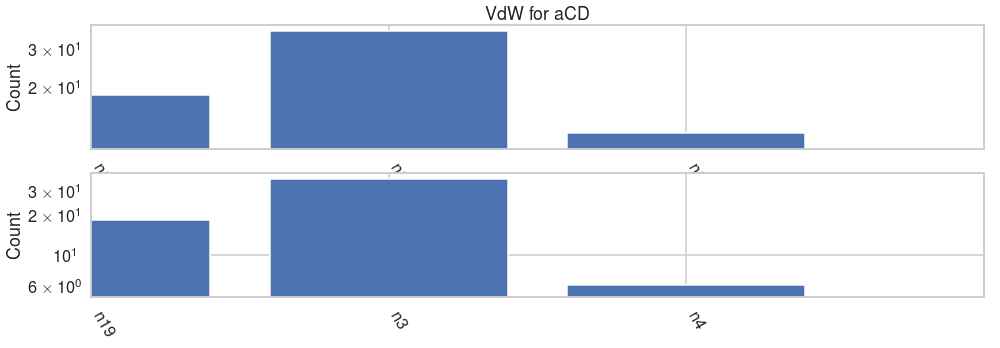

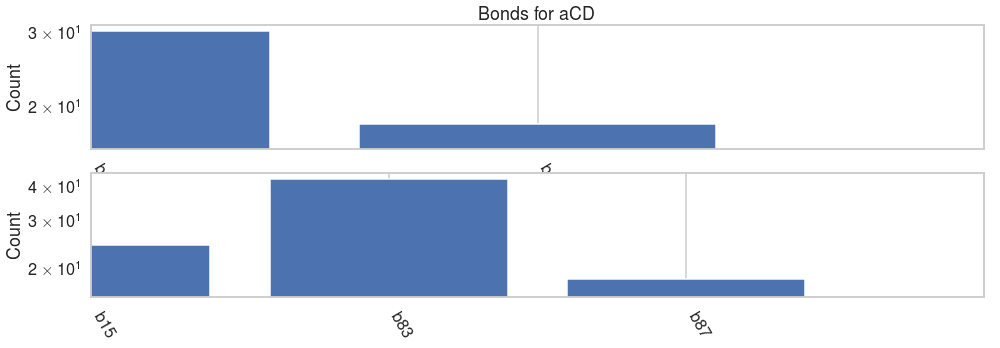

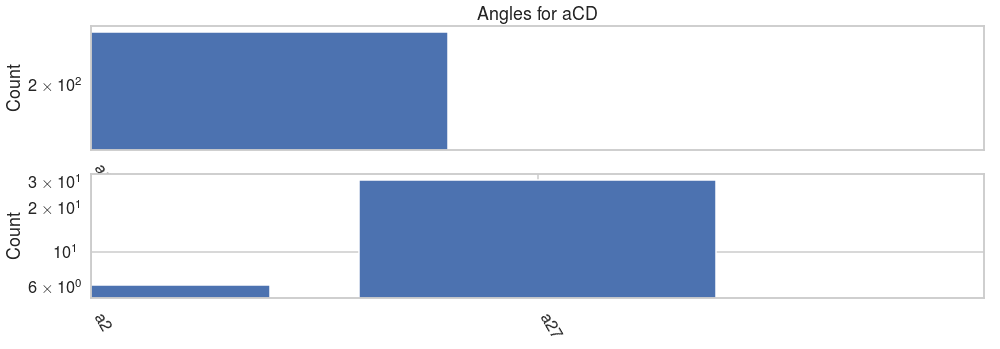

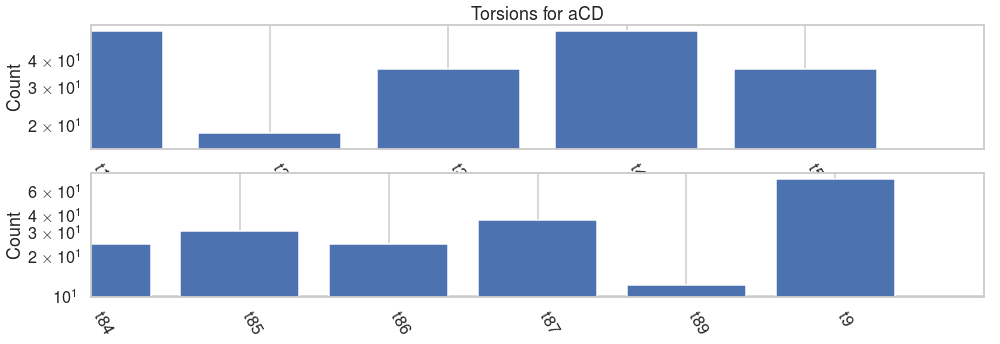

In [29]:
# Create Hisogram for each type of parameter
# VdW
make_param_histogram(param_id_counts, param_ids, 'n', "VdW for aCD")
# Bonds
make_param_histogram(param_id_counts, param_ids, 'b', "Bonds for aCD")
# Angles
make_param_histogram(param_id_counts, param_ids, 'a', "Angles for aCD")
# Torsions
make_param_histogram(param_id_counts, param_ids, 't', "Torsions for aCD")

In [32]:
param_id_counts

{'t4': 54,
 't87': 36,
 't3': 36,
 't84': 24,
 't1': 54,
 't2': 18,
 'n18': 12,
 'n12': 18,
 't9': 72,
 'n3': 36,
 'a27': 30,
 'b14': 18,
 'b83': 42,
 'b87': 18,
 'b15': 24,
 't86': 24,
 'b1': 30,
 'a2': 6,
 'n16': 36,
 't5': 36,
 't89': 12,
 'n4': 6,
 'a1': 210,
 't85': 30,
 'n19': 18}

In [35]:
torsion_names, torsion_counts = [], []
for key, value in param_id_counts.items():
    if key[0] == "t":
        torsion_names.append(key)
        torsion_counts.append(value)

In [40]:
np.argsort(torsion_counts)

array([ 9,  5,  3,  7, 10,  1,  2,  8,  0,  4,  6])

In [44]:
sorted_counts = np.sort(torsion_counts)
sorted_names = [torsion_names[i] for i in np.argsort(torsion_counts)]

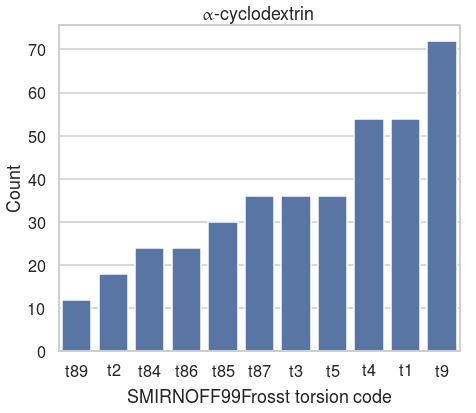

In [67]:
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
sns.barplot(sorted_names, sorted_counts, color="b")
ax.set_ylabel("Count")
ax.set_xlabel("SMIRNOFF99Frosst torsion code", labelpad=10)
ax.set_title(r"$\alpha$-cyclodextrin")

In [48]:
import seaborn as sns